In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.append('D:/thesis/src')
from two_level_clustering.Merging import Merging

from sklearn import metrics

In [2]:
def model_info(model_labels, true_labels):
    # Function that shows crosstab of cluster and actual labels

    df = pd.DataFrame({'clust_label': model_labels, 'orig_label': true_labels})
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    display(ct)


def clustering_quality(y_true, y_pred):
    ari = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    v_measure = metrics.v_measure_score(y_true, y_pred)
    fm_score = metrics.fowlkes_mallows_score(y_true, y_pred)
    
    print("Adjusted Rand Index:", ari)
    print("Normalized Mutual Information:", nmi)
    print("Adjusted Mutual Information:", ami)
    print("V-Measure:", v_measure)
    print("Fowlkes-Mallows Score:", fm_score)
    
    return ari, nmi, ami, v_measure, fm_score

In [154]:
from sklearn.mixture import GaussianMixture

class Algorithm2:
    '''GMM + BIC + Entropy'''

    def __init__(self, kmin, kmax, verbose):
        self.kmin = kmin
        self.kmax = kmax
        self.verbose_ = verbose
        self.labels_ = None
    
    def fit(self, X):
        min_bic = np.inf
        k_best = None
        best_model = None

        for k in range(self.kmin, self.kmax + 1):
            gmm = GaussianMixture(n_components=k, init_params='k-means++', covariance_type='full', tol=1e-5, max_iter=400)
            # Fit the model to the data
            gmm.fit(X)

            gmm_bic = gmm.bic(X)
            if gmm_bic < min_bic:
                min_bic = gmm_bic
                k_best = k

                best_model = gmm
            
        print("Best K:{}, BIC:{}".format(k_best, gmm_bic))

        weights, means, covs = best_model.weights_, best_model.means_, best_model.covariances_
        merging = Merging(weights, means, covs, 'entropy', verbose=self.verbose_)
        merging.fit(X)

        self.labels_ = merging.labels_

### GvHd positive sample dataset

In [155]:
df = pd.read_csv("..//data/GvHD_pos.csv") 

In [156]:
df

,CD4,CD8b,CD3,CD8
0,308,220,157,339
1,319,271,223,350
2,215,148,119,221
3,104,49,284,178
4,262,167,144,156
...,...,...,...,...
9078,121,53,51,180
9079,194,182,203,199
9080,201,183,115,227
9081,241,213,166,212


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


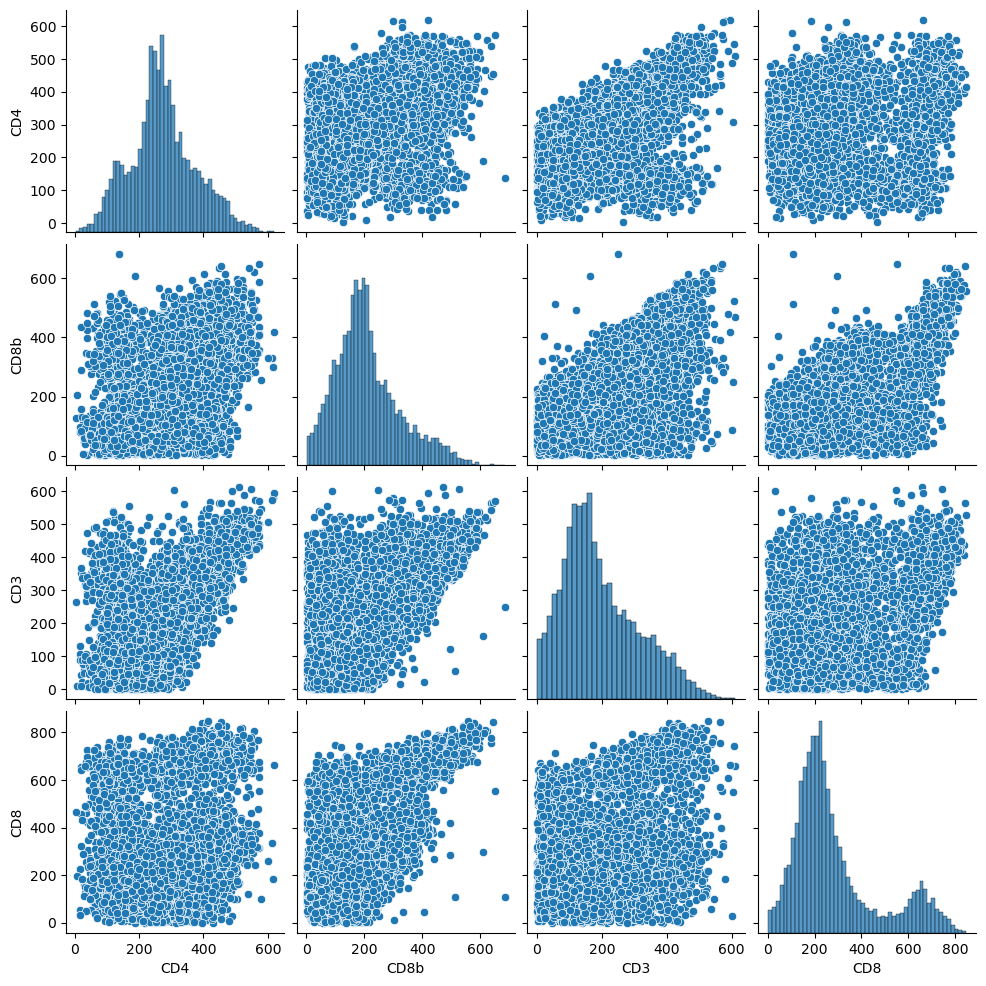

In [157]:
sns.pairplot(df)

In [158]:
data = df.to_numpy()

In [159]:
data

array([[308, 220, 157, 339],
       [319, 271, 223, 350],
       [215, 148, 119, 221],
       ...,
       [201, 183, 115, 227],
       [241, 213, 166, 212],
       [223, 184,  69, 279]], dtype=int64)

### Obtaining best clustering using GMM-Entropy

In [160]:
algorithm2 = Algorithm2(kmin=2, kmax=20, verbose=True)

Best K:11, BIC:417270.8834279881
Best pair:3, 7 to merge
Best pair:3, 4 to merge
Best pair:0, 3 to merge
Best pair:0, 9 to merge
Best pair:0, 2 to merge
Best pair:0, 10 to merge
Best pair:0, 5 to merge
Best pair:0, 1 to merge
Best pair:0, 6 to merge
Best pair:0, 8 to merge


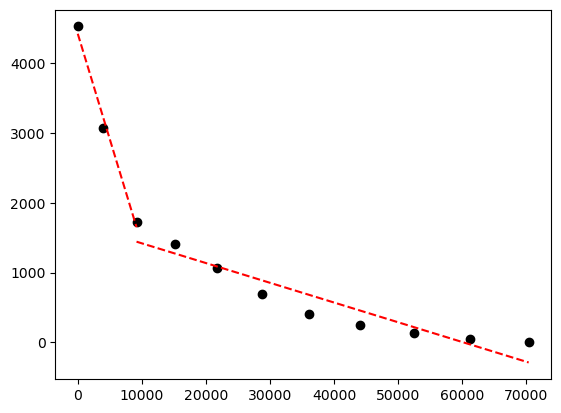

Clusters removed number:2


In [161]:
algorithm2.fit(data)

In [162]:
y_pred = algorithm2.labels_

In [163]:
len(np.unique(y_pred))

9

In [164]:
combined_df = pd.concat([df, pd.Series(y_pred, name='cluster_label')], axis=1)

# Calculate the mean for each cluster
cluster_means = combined_df.groupby('cluster_label').mean()

# Check which clusters have a mean greater than 280
clusters_greater_than_280 = cluster_means[cluster_means['CD3'] > 280]

In [165]:
cluster_means['CD3']

cluster_label
0.0     291.660598
1.0     368.176661
2.0      70.025729
3.0     152.874552
5.0      63.747253
6.0     281.233422
8.0     359.257384
9.0     295.288660
10.0    395.446629
Name: CD3, dtype: float64

In [166]:
selected_clusters = clusters_greater_than_280.index.to_numpy()

In [167]:
selected_clusters

array([ 0.,  1.,  6.,  8.,  9., 10.])

In [168]:
filtered_df = combined_df[combined_df['cluster_label'].isin(selected_clusters)]

<Axes: xlabel='CD4', ylabel='CD8b'>

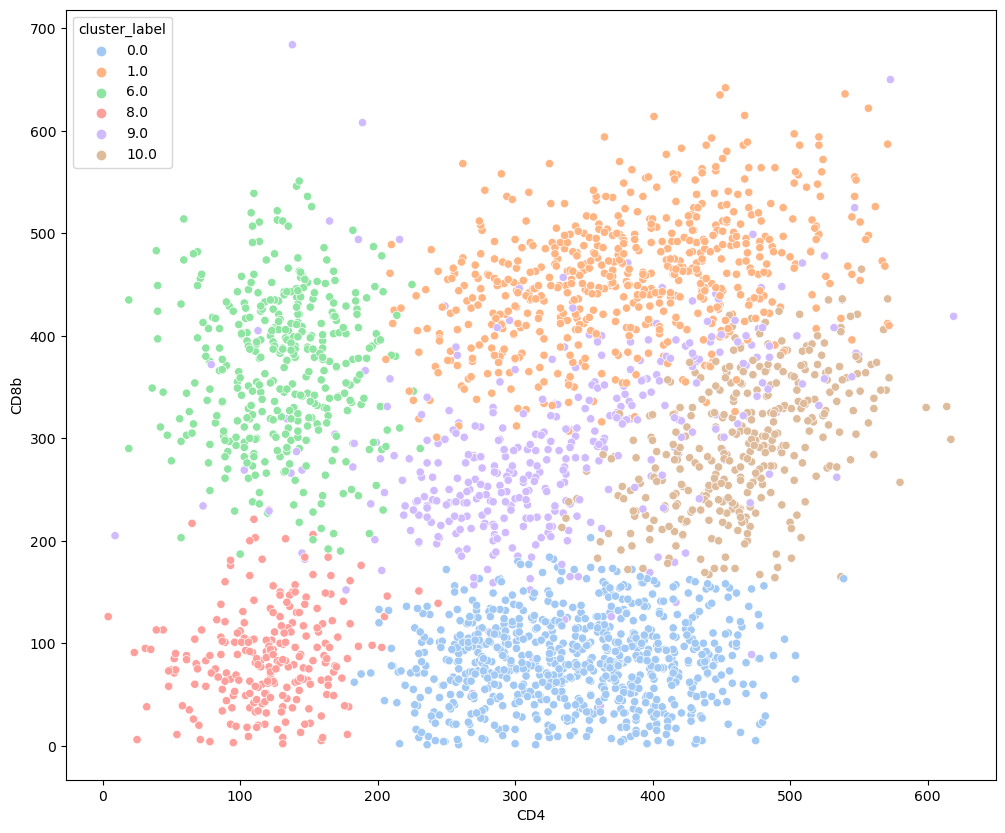

In [169]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=filtered_df, x='CD4', y='CD8b', hue='cluster_label', palette='pastel', ax=ax)

In [178]:
combined_df = combined_df.astype({'cluster_label': int})

In [179]:
combined_df

,CD4,CD8b,CD3,CD8,cluster_label
0,308,220,157,339,3
1,319,271,223,350,3
2,215,148,119,221,3
3,104,49,284,178,8
4,262,167,144,156,3
...,...,...,...,...,...
9078,121,53,51,180,2
9079,194,182,203,199,3
9080,201,183,115,227,3
9081,241,213,166,212,3


In [183]:
combined_df.to_csv('../data/GvHD_pos_clustered.csv', index=False)